# Overview 

This script explores the dataset `gestures-hand` then the dataset is used to train a CNN model and plot its accuracy and loss.



# Importing dependencies

First let us import all the modules and packages that will be required.

In [31]:
# Importing import modules
import numpy as np # linear algebra
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from skimage import io
import random
from keras.preprocessing import image
from keras.models import load_model

print(os.listdir("../input/gestures-hand/data/data"))

['validation', 'test', 'train']


The dataset is already been split into train, test and validation (so we dont need to do it later on) 

In [2]:
# Train, test and validation directories
train_dir = "../input/gestures-hand/data/data/train"
val_dir = "../input/gestures-hand/data/data/validation"
test_dir = "../input/gestures-hand/data/data/test"

# Exploring the Dataset

The dataset contains three different directories called `train`, `test` and `validation`. Each of these directories contain 7 sub-directories which essentially refer to the six types of hand gestures i.e. `five`, `fist`, `rad`, `okay`, `peace`, `straight` and `thumbs`. Additionally, there is a `none` directory which contains images of the background without any hand in it which can be used as initial background setup. 

All the images in the dataset have been preprocessed already via OpenCV's background subtraction algorithms by the following steps :
* Applying smoothing filter that keeps edges sharp using `cv2.bilateralFilter`
* Removing background like eroding background using `cv2.erode` , etc.
* Create a background mask
* Created a Region of Interest (ROI)
* Converting image to gray using `cv2.cvtColor`
* Blurring the image using `cv2.GaussianBlur`
* Thresholding the image using `cv2.threshold`


## Visualising each gesture 
Show one image of the each of the 8 classes present.

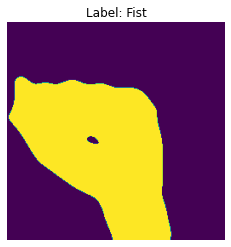

In [3]:
img_array1 = np.array(Image.open('../input/gestures-hand/data/data/train/fist/123.png'))
plt.imshow(img_array1)
plt.title("Label: Fist")
plt.axis('off')
plt.show()

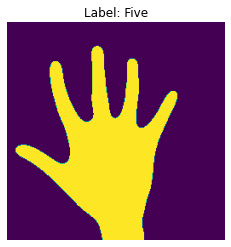

In [4]:
img_array2 = np.array(Image.open('../input/gestures-hand/data/data/train/five/123.png'))
plt.imshow(img_array2)
plt.title("Label: Five")
plt.axis('off')
plt.show()

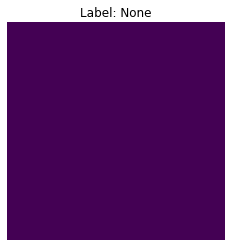

In [5]:
img_array3 = np.array(Image.open('../input/gestures-hand/data/data/train/none/123.png'))
plt.imshow(img_array3)
plt.title("Label: None")
plt.axis('off')
plt.show()

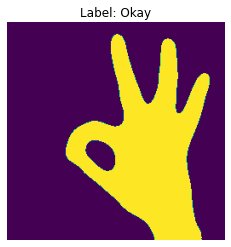

In [6]:
img_array4 = np.array(Image.open('../input/gestures-hand/data/data/train/okay/123.png'))
plt.imshow(img_array4)
plt.title("Label: Okay")
plt.axis('off')
plt.show()

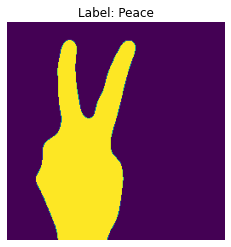

In [7]:
img_array5 = np.array(Image.open('../input/gestures-hand/data/data/train/peace/123.png'))
plt.imshow(img_array5)
plt.title("Label: Peace")
plt.axis('off')
plt.show()

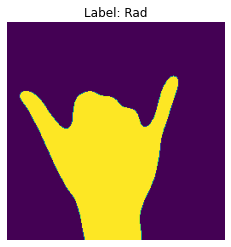

In [8]:
img_array6 = np.array(Image.open('../input/gestures-hand/data/data/train/rad/123.png'))
plt.imshow(img_array6)
plt.title("Label: Rad")
plt.axis('off')
plt.show()

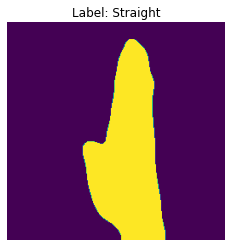

In [9]:
img_array7 = np.array(Image.open('../input/gestures-hand/data/data/train/straight/123.png'))
plt.imshow(img_array7)
plt.title("Label: Straight")
plt.axis('off')
plt.show()

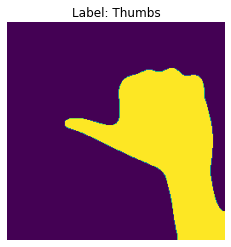

In [10]:
img_array8 = np.array(Image.open('../input/gestures-hand/data/data/train/thumbs/123.png'))
plt.imshow(img_array8)
plt.title("Label: Thumbs")
plt.axis('off')
plt.show()

# Preparation for Model Training 

The variable `outputSize` refers to the number of different hand gestures in the dataset. Since it is a multi-class classification model, this will determine the number of units in the final dense layer preceeding the softmax activation.

In [11]:
# Declaring variables
outputSize = len(os.listdir(train_dir)) 
epochs = 15# Number of epochs

## Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

The Keras deep learning neural network library provides the capability to fit models using image data augmentation via the `ImageDataGenerator` class.

First, the class may be instantiated and the configuration for the types of data augmentation are specified by arguments to the class constructor.

A range of techniques are supported, as well as pixel scaling methods. We will focus on four main types of data augmentation techniques for image data; specifically:

 * Image shifts via the `width_shift_range` and `height_shift_range` arguments.
 *   Image flips via the `horizontal_flip` arguments.
 *  Shear angle in counter-clockwise direction in degrees via the `shear_range` argument.
 *  Image zoom via the `zoom_range `argument.


In [12]:
# Train Data Generator to do data augmentation on training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [13]:
# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Setting up the train generator to flow from the train directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

# Doing the same as above for the validation directory
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 7999 images belonging to 8 classes.
Found 3999 images belonging to 8 classes.


### Visualizing Augmented Data

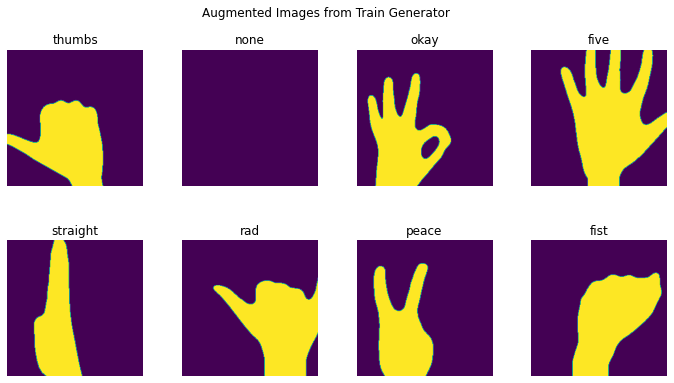

In [15]:
# Get the class labels
class_labels = train_generator.class_indices

# Select 8 random classes
selected_classes = np.random.choice(list(class_labels.keys()), 8, replace=False)

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot augmented images from the train generator for the selected classes
for i, gesture_class in enumerate(selected_classes):
    # Find the index of the gesture class
    class_index = class_labels[gesture_class]
    
    # Find the first image in the train generator for the selected class
    image_index = np.argmax(train_generator.classes == class_index)
    image = train_generator._get_batches_of_transformed_samples([image_index])[0][0]
    
    # Plot the image
    ax = axes[i // 4, i % 4]
    ax.imshow(np.squeeze(image))
    ax.set_title(gesture_class)
    ax.axis('off')

plt.suptitle('Augmented Images from Train Generator')
plt.show()



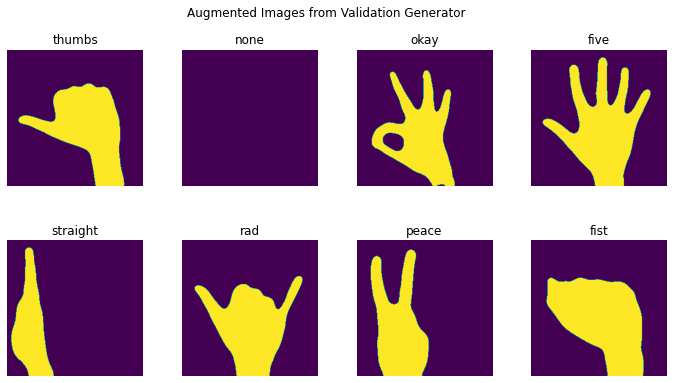

In [16]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot augmented images from the validation generator for the selected classes
for i, gesture_class in enumerate(selected_classes):
    # Find the index of the gesture class
    class_index = class_labels[gesture_class]
    
    # Find the first image in the validation generator for the selected class
    image_index = np.argmax(val_generator.classes == class_index)
    image = val_generator._get_batches_of_transformed_samples([image_index])[0][0]
    
    # Plot the image
    ax = axes[i // 4, i % 4]
    ax.imshow(np.squeeze(image))
    ax.set_title(gesture_class)
    ax.axis('off')

plt.suptitle('Augmented Images from Validation Generator')
plt.show()


# Model

## Defining the CNN


In [17]:
# Function to create keras model for different number of gestures
def create_model(outputSize):
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dropout(rate = 0.5))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(units = outputSize, activation = 'softmax'))
    model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
# Creating the model
model = create_model(outputSize)

In [19]:
# Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 128)       7

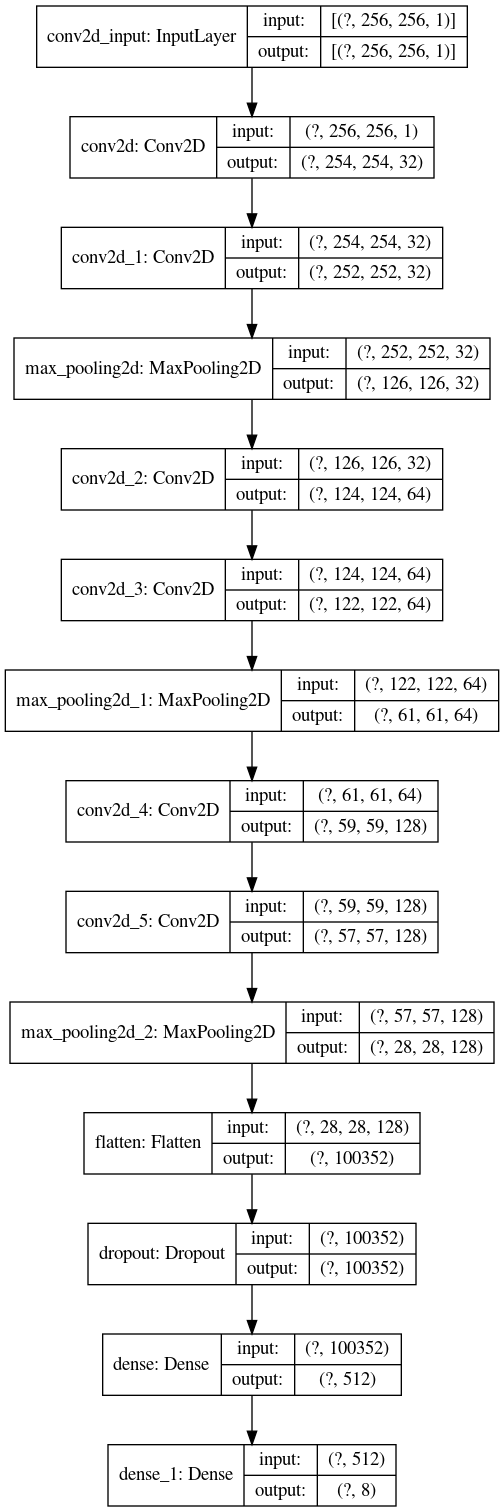

In [20]:
#Model image
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

### Fitting the Model 

In [21]:
# Fitting the model to the data based on a 32 batch size
history = model.fit_generator(
    train_generator,
    steps_per_epoch=outputSize*1000/32,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=outputSize*500/32
)

Epoch 1/15
250/250 [==============================] - 122s 487ms/step - loss: 0.8865 - accuracy: 0.6652 - val_loss: 0.5357 - val_accuracy: 0.7774
Epoch 2/15
250/250 [==============================] - 58s 231ms/step - loss: 0.3965 - accuracy: 0.8556 - val_loss: 0.4646 - val_accuracy: 0.8265
Epoch 3/15
250/250 [==============================] - 58s 232ms/step - loss: 0.2798 - accuracy: 0.9015 - val_loss: 0.3388 - val_accuracy: 0.8595
Epoch 4/15
250/250 [==============================] - 59s 237ms/step - loss: 0.2201 - accuracy: 0.9236 - val_loss: 0.2147 - val_accuracy: 0.9245
Epoch 5/15
250/250 [==============================] - 59s 235ms/step - loss: 0.1872 - accuracy: 0.9356 - val_loss: 0.0989 - val_accuracy: 0.9707
Epoch 6/15
250/250 [==============================] - 59s 238ms/step - loss: 0.1530 - accuracy: 0.9499 - val_loss: 0.1795 - val_accuracy: 0.9412
Epoch 7/15
250/250 [==============================] - 59s 237ms/step - loss: 0.1342 - accuracy: 0.9550 - val_loss: 0.0951 - val_a

# Results and Performance Metrics

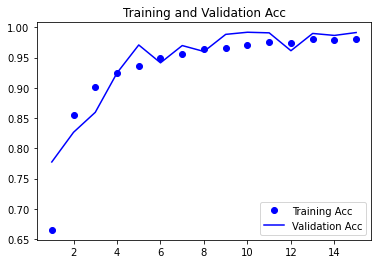

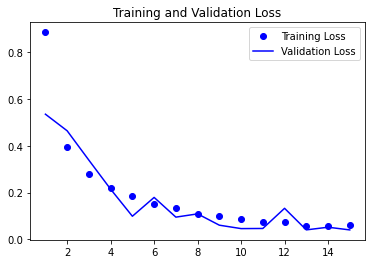

<Figure size 432x288 with 0 Axes>

In [22]:
# Plotting training acc/loss and val acc/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
range_ep = epochs +1
epoch_x = range(1, range_ep)

plt.plot(epoch_x,acc,'bo',label="Training Acc")
plt.plot(epoch_x,val_acc,'b',label='Validation Acc')
plt.title('Training and Validation Acc')
plt.legend()
plt.figure()

plt.plot(epoch_x,loss,'bo',label="Training Loss")
plt.plot(epoch_x,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

plt.show()

In [23]:
# Setting up the test generator to flow from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 4000 images belonging to 8 classes.


In [24]:
# Test accuracy and test loss calc
test_loss, test_acc = model.evaluate_generator(test_generator,steps = outputSize*500/32)
print("Test Acc: {:.3f}%".format(round(test_acc*100, 3)))
print("Test Loss: {:.3f}%".format(round(test_loss*100, 3)))

Test Acc: 98.675%
Test Loss: 3.455%


# Saving Model and Model Weights

Model progress can be saved during and after training. This means a model can resume where it left off and avoid long training times. Saving also means you can share your model and others can recreate your work. When publishing research models and techniques, most machine learning practitioners share:

  * code to create the model, and
  * the trained weights, or parameters, for the model


In [25]:
# Model weights and model
model.save_weights('gesture_model_weights.h5')
model.save("gesture_model.h5")

# Test Runs

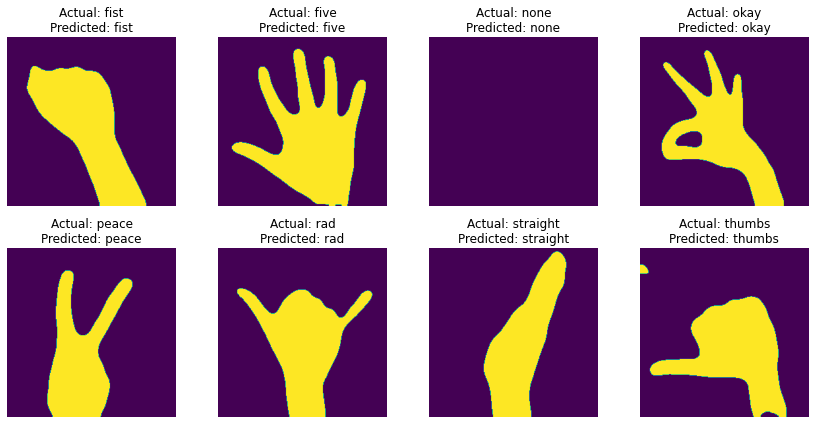

In [32]:
# Load the saved model
loaded_model = load_model('gesture_model.h5')

# Set the path to the test folder
test_folder = '/kaggle/input/gestures-hand/data/test'  # Replace with the actual path to the test folder

# Get the list of subfolders (class labels) in the test folder
class_labels = sorted(os.listdir(test_folder))

# Select 8 random images from the test folder
num_images = 8
selected_images = []

for class_label in class_labels:
    class_path = os.path.join(test_folder, class_label)
    images = os.listdir(class_path)
    random_images = random.sample(images, num_images // len(class_labels))
    selected_images.extend([os.path.join(class_path, image) for image in random_images])

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Make predictions for the selected images and plot them
for i, image_path in enumerate(selected_images):
    img = image.load_img(image_path, target_size=(256, 256), grayscale=True)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction)
    gesture_label = class_labels[predicted_class]
    actual_label = os.path.basename(os.path.dirname(image_path))

    # Plot the image and show the labels
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(f'Actual: {actual_label}\nPredicted: {gesture_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()


# User Input

### Preprocessing the Image

In [27]:
import cv2
import numpy as np

def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours of the gesture
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the gesture contour
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Create the output image with isolated gesture and background colors
    output_image = np.where(mask == (255, 255, 255), (128, 0, 128), (0, 255, 255))

    # Convert output image to uint8 data type
    output_image = output_image.astype(np.uint8)

    return output_image

### Predicting the Hand Gesture

Enter image path /kaggle/input/user-input/fist.jpg


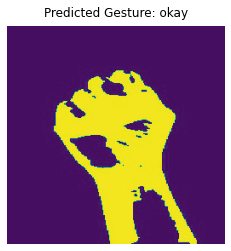

In [30]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
 
# Load the saved model
loaded_model = load_model('gesture_model.h5')

# Load the image for prediction
image_path =input("Enter image path")
print('\n')
img=process_image(image_path)
img = image.load_img(image_path, target_size=(256, 256), grayscale=True)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make prediction
prediction = loaded_model.predict(img_array)
predicted_class = np.argmax(prediction)

# Get the class label
class_labels = train_generator.class_indices
gesture_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class)]

# Plot the input image in the center
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

# Add the predicted gesture label as the title
plt.title(f'Predicted Gesture: {gesture_label}', fontsize=12, pad=10)
plt.show()


# Future Work

The model can be improved by 
- reducing overfitting by earlystopping
- random train test split
- using different model

